**[step01]** ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,datasets
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

**[step02]** モデルの構築 - Convolutional Neural Network

256 * 256<br>
↓(5 * 5,　6)<br>
252 * 252<br>
↓(2 * 2)<br>
126 * 126<br>

↓(3 * 3,16)    ↓(5 * 5, 16)<br>
124 * 124      122 * 122<br>
↓(2 * 2)       ↓(2 * 2)<br>
62 * 62        61 * 61<br>

↓(5 * 5, 32)<br>
58 * 58<br>
↓(2 * 2)<br>
29 * 29<br>

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        #self.conv3 = nn.Conv2d(16,32,5)
        # 線形変換
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        # 畳み込み層 -> プーリング層 -> 畳み込み層 -> プーリング層
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 61 * 61)
        # 全結合層
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**画像サイズ32*32の場合**<br>
**5クラス分類用**<br>
**畳み込み層：2**<br>
**プーリング層：2**<br>
**全結合層：3**<br>

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        # 線形変換
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        # 畳み込み層 -> プーリング層 -> 畳み込み層 -> プーリング層
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        # 全結合層
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**[step03]** 学習データセットの生成

In [3]:
# データの形状などを指定 今回の画像サイズは 32 * 32 に指定
data_transform = transforms.Compose([
        #transforms.RandomResizedCrop(32),
        #transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

#train_dir = 'train_data/train'
#val_dir = 'train_data/val'
train_dir = 'actress_ex_data/train_data_256/train/'
val_dir = 'actress_ex_data/train_data_256/val/'
#train_dir = 'actress_ex_data/train_data_32/train/'
#val_dir = 'actress_ex_data/train_data_32/val/'
#train_dir = 'actress_ex_data/train_data_32to256/train/'
#val_dir = 'actress_ex_data/train_data_32to256/val/'
#train_dir = 'actress_ex_data/train_data_mix/train/'
#val_dir = 'actress_ex_data/train_data_mix/val/'

# 訓練用データ
actress_dataset = datasets.ImageFolder(root=train_dir,
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(actress_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

# テスト用データ
actress_testset = datasets.ImageFolder(root=val_dir,
                               transform=data_transform)
dataset_testloader = torch.utils.data.DataLoader(actress_testset, batch_size=4,
                                         shuffle=False, num_workers=4)

# 女優の名前クラス 動的に変えたい
classes = ('Kanna', 'Maki', 'Suzu','Yurina')
#classes = ('Arimura', 'Gakky', 'Homaki', 'Ikeda', 'Toda')

**[step03-2]** 学習用画像データの確認

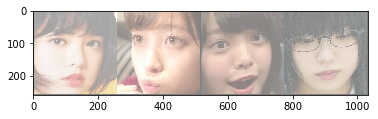

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()
    
# get some random training images
dataiter = iter(dataset_loader)
actress, name= dataiter.next()
 
# show images
imshow(torchvision.utils.make_grid(actress))
# print labels
#print(' '.join('%5s' % classes[name[j]] for j in range(4)))

**[step04]** 学習 ( 損失関数, 最適化関数の定義 )

In [12]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
steptime = 50
epochtime = 30

for epoch in range(epochtime):
    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        train_x, train_y = data
        #print(train_y.data)
        optimizer.zero_grad()
        prediction = net(train_x)
        loss = criterion(prediction, train_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print('loss: %.3f' %(running_loss))
        #if i%steptime == steptime-1:
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / steptime))
        #    running_loss = 0.0
    print('epoch: %d, loss: %.3f' % (epoch+1, running_loss / (i+1)))
print("Finished Training")

epoch: 1, loss: 1.588
epoch: 2, loss: 1.346
epoch: 3, loss: 1.229
epoch: 4, loss: 1.052
epoch: 5, loss: 1.015
epoch: 6, loss: 0.988
epoch: 7, loss: 0.860
epoch: 8, loss: 0.745
epoch: 9, loss: 0.627
epoch: 10, loss: 0.460
epoch: 11, loss: 0.576
epoch: 12, loss: 0.520
epoch: 13, loss: 0.213
epoch: 14, loss: 0.132
epoch: 15, loss: 0.117
epoch: 16, loss: 0.092
epoch: 17, loss: 0.194
epoch: 18, loss: 0.081
epoch: 19, loss: 0.040
epoch: 20, loss: 0.080
epoch: 21, loss: 0.037
epoch: 22, loss: 0.027
epoch: 23, loss: 0.011
epoch: 24, loss: 0.007
epoch: 25, loss: 0.004
epoch: 26, loss: 0.003
epoch: 27, loss: 0.001
epoch: 28, loss: 0.001
epoch: 29, loss: 0.001
epoch: 30, loss: 0.001
Finished Training


**[step05]** テスト - 女優の顔を名前クラスに分類する

tensor([0, 3, 0, 0]) tensor([0, 0, 0, 0]) tensor(3)
Kanna       Yurina       Kanna       Kanna


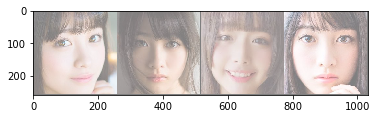

tensor([0, 0, 1, 1]) tensor([0, 0, 1, 1]) tensor(7)
Kanna       Kanna        Maki        Maki


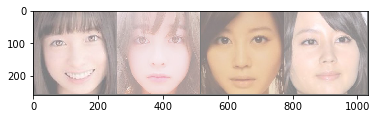

tensor([1, 2, 1, 1]) tensor([1, 1, 1, 1]) tensor(10)
 Maki        Suzu        Maki        Maki


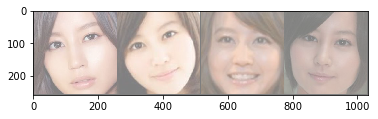

tensor([1, 1, 2, 2]) tensor([2, 2, 2, 2]) tensor(12)
 Maki        Maki        Suzu        Suzu


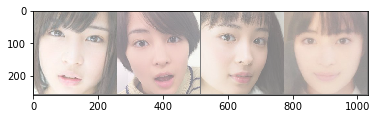

tensor([1, 2, 3, 3]) tensor([2, 2, 3, 3]) tensor(15)
 Maki        Suzu       Yurina       Yurina


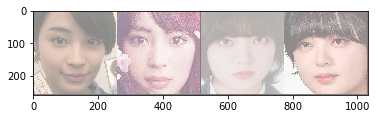

tensor([3, 3, 3, 3]) tensor([3, 3, 3, 3]) tensor(19)
Yurina       Yurina       Yurina       Yurina


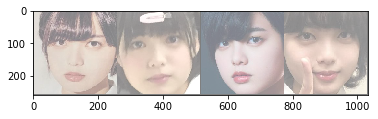

24 tensor(19) tensor(79)
Accuracy [actress images]: 79 %


In [13]:
correct = 0
total = 0
for data in dataset_testloader:
    images, labels = data
    outputs = net(torch.autograd.Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    print(predicted, labels, correct)
    print('       '.join('%5s' % classes[predicted[j]] for j in range(4)))
    img = torchvision.utils.make_grid(images) / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print(total, correct, 100*correct/total)
print('Accuracy [actress images]: %d %%' % (100 * correct / total))

画像データ : 256*256
テストデータ : 256*256
30 epoch
畳み込み2層　プーリング２層
正解率 : 79% , 83%

画像データ : 256*256 transformなし
テストデータ : 256*256　transformなし
30 epoch
畳み込み2層　プーリング２層
正解率 : 83%

画像データ : 256*256 -> 32*32
テストデータ : 256*256 -> 32*32
30 epoch
畳み込み2層 プーリング2層
正解率 : 70%



画像データ : 32*32
テストデータ : 32*32
30 epoch
畳み込み2層　プーリング２層
正解率 : 83% , 83%

画像データ : 32*32 transformなし
テストデータ : 32*32　transformなし
30 epoch
畳み込み2層　プーリング２層
正解率 : 66%
50 epoch
正解率 : 75%




画像データ : 32*32 -> 256*256
テストデータ : 32*32 -> 256*256
30 epoch
畳み込み２層　プーリング２層
正解率 : 70%

画像データ : 32*32 -> 256*256 (事前加工)
テストデータ : 32*32 -> 256*256 (事前加工)
30 epoch
畳み込み２層　プーリング２層
正解率 : 87%

画像データ : 32*32 -> 256*256 (事前加工) -> 32*32
テストデータ : 32*32 -> 256*256 (事前加工) -> 32*32
30 epoch
畳み込み２層　プーリング２層
正解率 : 75%

画像データ : 32*32, 256*256 <- mix_data -> 256*256 データ数倍
テストデータ : 32*32, 256*256 <- mix_data -> 256*256
30 epoch
畳み込み２層　プーリング２層
正解率 : 83%

画像データ : 256*256 -> 32*32
テストデータ : 32*32
30 epoch
畳み込み2層 プーリング2層
正解率 : 70%

画像データ : 32*32 -> 256*256
テストデータ : 256*256
30 epoch
畳み込み２層　プーリング２層
正解率 : 75%



画像データ : 32*32 -> 256*256 (事前加工)
テストデータ : 256*256
30 epoch
畳み込み２層　プーリング２層
正解率 : 70%

画像データ : 32*32 -> 256*256 (事前加工) transformなし
テストデータ : 256*256　transformなし
30 epoch
畳み込み2層　プーリング２層
正解率 : 79%